In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [4]:
from synthetic_utils import *

In [41]:
from trainer_dataloader import *
from networks import *
from losses import *

In [6]:
input_size = 96
batch_size = 128
num_workers = 4
num_epochs = 20

In [7]:
cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))

Device set: cuda


In [8]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
#             transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}

In [9]:
DATA_PATH = '/home/var/synthetic_data/dependent_gen/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

In [10]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [11]:
train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

## Train only encoder first


In [12]:
encoder = LeNet()
classifier = ClassNet()

In [13]:
criterion = nn.BCELoss()
opt_cls = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_enc = optim.Adam(encoder.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_cls = lr_scheduler.StepLR(optimizer=opt_cls, gamma=0.99, step_size=1)
scheduler_enc = lr_scheduler.StepLR(optimizer=opt_enc, gamma=0.99, step_size=1)

In [14]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_cls.step()
        scheduler_enc.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(train_loader, encoder,
                                classifier, opt_enc,
                                opt_cls, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(val_loader, encoder, classifier,
                                 criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 2.499 (2.499)	Loss 0.6942 (0.6942)	Accuracy 0.4766 (0.4766)
Batch: [5/40]	Time 0.431 (0.756)	Loss 0.5716 (0.6412)	Accuracy 0.7266 (0.5951)
Batch: [10/40]	Time 0.259 (0.637)	Loss 0.5796 (0.5999)	Accuracy 0.7422 (0.6669)
Batch: [15/40]	Time 0.080 (0.574)	Loss 0.5199 (0.5799)	Accuracy 0.7422 (0.6968)
Batch: [20/40]	Time 0.966 (0.588)	Loss 0.5235 (0.5630)	Accuracy 0.7578 (0.7106)
Batch: [25/40]	Time 0.498 (0.583)	Loss 0.5926 (0.5542)	Accuracy 0.7344 (0.7197)
Batch: [30/40]	Time 0.428 (0.576)	Loss 0.4539 (0.5441)	Accuracy 0.8047 (0.7276)
Batch: [35/40]	Time 0.048 (0.556)	Loss 0.4549 (0.5327)	Accuracy 0.8359 (0.7365)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 2.322 (2.322)	Loss 0.3682 (0.3682)	Accuracy 0.8594 (0.8594)
Avg validation loss: 0.4701332855224609 	 Accuracy: 0.804
--------------------
Epoch 0/20	Time 24.248 sec (24.248 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 2.625 (2.625)	Loss 0.3642 (0.3642)	Accuracy 0.8438 (0.8438)
Batch: [5/40]	Time 0.111 (0.810)	Loss 0.4865 (0.4890)	Accuracy 0.7344 (0.7604)
Batch: [10/40]	Time 0.085 (0.653)	Loss 0.4109 (0.4645)	Accuracy 0.8359 (0.7685)
Batch: [15/40]	Time 0.064 (0.597)	Loss 0.4383 (0.4514)	Accuracy 0.8359 (0.7856)
Batch: [20/40]	Time 2.014 (0.660)	Loss 0.4366 (0.4472)	Accuracy 0.7734 (0.7883)
Batch: [25/40]	Time 0.088 (0.622)	Loss 0.3897 (0.4386)	Accuracy 0.8594 (0.7960)
Batch: [30/40]	Time 0.086 (0.593)	Loss 0.2843 (0.4243)	Accuracy 0.8672 (0.8027)
Batch: [35/40]	Time 0.052 (0.572)	Loss 0.3608 (0.4150)	Accuracy 0.8516 (0.8082)
----------
Test: [0/4]	Time 2.007 (2.007)	Loss 0.4225 (0.4225)	Accuracy 0.8203 (0.8203)
Avg validation loss: 0.38736174249649047 	 Accuracy: 0.842
--------------------
Epoch 1/20	Time 24.330 sec (24.289 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 2.625 (2.625)	Loss 0.2850 (0.2850)	Accuracy 0.9062 (0.9062)
Batch: [5/40]	Time 0.068 (0.822)	Loss 0.26

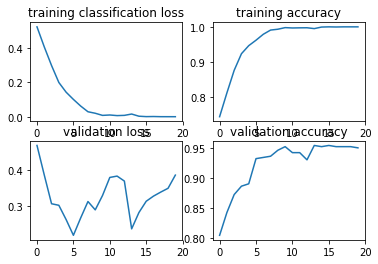

In [15]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)

## Train only adversary

In [16]:
from synthetic_dataloader import *
gender_train = GenderDataset(train_df)
gender_valid = GenderDataset(val_df)

In [17]:
advtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
advval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

In [18]:
adv_encoder = LeNet()
adversary = ClassNet()

In [19]:
adv_criterion = nn.BCELoss()
opt_adv = optim.Adam(adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_adv_enc = optim.Adam(adv_encoder.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_adv = lr_scheduler.StepLR(optimizer=opt_adv, gamma=0.99, step_size=1)
scheduler_adv_enc = lr_scheduler.StepLR(optimizer=opt_adv_enc, gamma=0.99, step_size=1)

In [20]:
num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_adv_enc.step()
        scheduler_adv.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(advtrain_loader,adv_encoder,
                                adversary, opt_adv_enc,
                                opt_adv, adv_criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(advval_loader, adv_encoder, adversary,
                                 adv_criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.084 (1.084)	Loss 0.7013 (0.7013)	Accuracy 0.4609 (0.4609)
Batch: [5/40]	Time 0.457 (0.521)	Loss 0.5927 (0.6509)	Accuracy 0.6172 (0.5885)
Batch: [10/40]	Time 0.066 (0.430)	Loss 0.3986 (0.5733)	Accuracy 0.7891 (0.6768)
Batch: [15/40]	Time 0.060 (0.392)	Loss 0.3673 (0.5211)	Accuracy 0.8203 (0.7109)
Batch: [20/40]	Time 0.568 (0.394)	Loss 0.3361 (0.4852)	Accuracy 0.8672 (0.7418)
Batch: [25/40]	Time 0.165 (0.385)	Loss 0.2778 (0.4505)	Accuracy 0.8516 (0.7647)
Batch: [30/40]	Time 0.062 (0.375)	Loss 0.1949 (0.4163)	Accuracy 0.9219 (0.7848)
Batch: [35/40]	Time 0.099 (0.367)	Loss 0.1532 (0.3833)	Accuracy 0.9297 (0.8032)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 1.153 (1.153)	Loss 0.2465 (0.2465)	Accuracy 0.9062 (0.9062)
Avg validation loss: 0.14997738248109818 	 Accuracy: 0.938
--------------------
Epoch 0/20	Time 15.704 sec (15.704 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.577 (1.577)	Loss 0.1478 (0.1478)	Accuracy 0.9453 (0.9453)
Batch: [5/40]	Time 0.038 (0.475)	Loss 0.1041 (0.1299)	Accuracy 0.9531 (0.9531)
Batch: [10/40]	Time 0.048 (0.395)	Loss 0.1027 (0.1094)	Accuracy 0.9609 (0.9588)
Batch: [15/40]	Time 0.063 (0.373)	Loss 0.0545 (0.0946)	Accuracy 0.9766 (0.9648)
Batch: [20/40]	Time 1.140 (0.407)	Loss 0.0634 (0.0872)	Accuracy 0.9688 (0.9676)
Batch: [25/40]	Time 0.046 (0.386)	Loss 0.1323 (0.0856)	Accuracy 0.9375 (0.9666)
Batch: [30/40]	Time 0.068 (0.374)	Loss 0.0328 (0.0781)	Accuracy 0.9922 (0.9705)
Batch: [35/40]	Time 0.300 (0.372)	Loss 0.0221 (0.0729)	Accuracy 0.9922 (0.9724)
----------
Test: [0/4]	Time 1.567 (1.567)	Loss 0.0314 (0.0314)	Accuracy 0.9844 (0.9844)
Avg validation loss: 0.01936145004630089 	 Accuracy: 0.994
--------------------
Epoch 1/20	Time 15.924 sec (15.814 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 1.748 (1.748)	Loss 0.0308 (0.0308)	Accuracy 0.9844 (0.9844)
Batch: [5/40]	Time 0.060 (0.500)	Loss 0.01

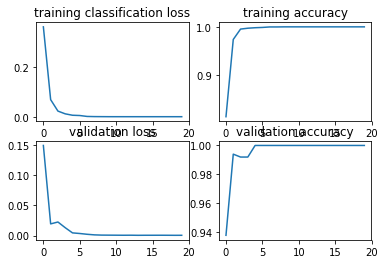

In [21]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)

## Train adversary on original encoder

## LAFTR Training

In [22]:
from synthetic_dataloader import *
gender_train = ShapeGenderDataset(train_df)
gender_valid = ShapeGenderDataset(val_df)

In [23]:
laftrtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
laftrval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

In [24]:
laftr_encoder = LeNet()
laftr_adversary = ClassNet()
laftr_classifier = ClassNet()

In [25]:
laftr_adv_criterion = AdvEqOddsLoss()
laftr_cls_criterion = nn.BCELoss()

In [26]:
laftr_opt_adv = optim.Adam(laftr_adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
laftr_opt_cls = optim.Adam(laftr_classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
laftr_opt_enc = optim.Adam(laftr_encoder.parameters(), lr=0.001, betas=(0.9, 0.999))

laftr_scheduler_adv = lr_scheduler.StepLR(optimizer=laftr_opt_adv, gamma=0.99, step_size=1)
laftr_scheduler_cls = lr_scheduler.StepLR(optimizer=laftr_opt_cls, gamma=0.99, step_size=1)
laftr_scheduler_enc = lr_scheduler.StepLR(optimizer=laftr_opt_enc, gamma=0.99, step_size=1)

In [27]:
num_epochs = 20

clsTrain_losses = []
clsTrain_accs = []
clsTrainCombined_losses = []
advTrain_losses = []
advTrain_accs = []
advTrainCombined_losses = []

combinedVal_losses = []
clsVal_losses = []
clsVal_accs = []
advVal_losses = []
advVal_accs = []

epoch_time = AverageMeter()

In [28]:
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))

        laftr_scheduler_adv.step()
        laftr_scheduler_cls.step()
        laftr_scheduler_enc.step()
        
        cls_loss, cls_en_combinedLoss, cls_en_acc, adv_loss, adv_combinedLoss, adv_acc = laftr_epoch(laftrtrain_loader,
                                                        laftr_encoder, laftr_classifier, laftr_adversary, laftr_opt_enc,
                                                        laftr_opt_cls, laftr_opt_adv, 
                                                        laftr_cls_criterion, laftr_adv_criterion, device)
        
        clsTrain_losses.append(cls_loss)
        clsTrain_accs.append(cls_en_acc)
        clsTrainCombined_losses.append(cls_en_combinedLoss)
        advTrain_losses.append(adv_loss)
        advTrain_accs.append(adv_acc)
        advTrainCombined_losses.append(adv_combinedLoss)
        
        print('Classifier accuracy: {}\t Adversary Accuracy: {}'.format(cls_en_acc, adv_acc))
        # validate
        print('-'*10)
        
        combinedVal_loss, clsVal_loss, clsVal_acc, advVal_loss, advVal_acc = laftr_validate(laftrval_loader,
                                                        laftr_encoder, laftr_classifier, laftr_adversary, 
                                                        laftr_cls_criterion, laftr_adv_criterion, device)
        
        combinedVal_losses.append(combinedVal_loss)
        clsVal_losses.append(clsVal_loss)
        clsVal_accs.append(clsVal_acc)
        advVal_losses.append(advVal_loss)
        advVal_accs.append(advVal_acc)
        
        print('Classifier validation acc: {:.4f} \t Adv validation acc: {:.4f}'.format(clsVal_acc, advVal_acc))
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.465 (1.465)
Classifier loss 0.6916 (0.6916)	Adversary loss -0.0584 (-0.0584)
Combined Loss during classifier step 0.6924 (0.6924)	Combined Loss during adversary step -0.6274 (-0.6274)
Classifier Accuracy 0.5234 (0.5234)	Adversary Accuracy 0.4688 (0.4688)
Batch: [5/40]	Time 0.201 (0.457)
Classifier loss 0.6103 (0.6716)	Adversary loss -0.8429 (-0.4287)
Combined Loss during classifier step 0.0284 (0.4347)	Combined Loss during adversary step 0.2500 (-0.2219)
Classifier Accuracy 0.7031 (0.5664)	Adversary Accuracy 0.1406 (0.3464)
Batch: [10/40]	Time 0.139 (0.387)
Classifier loss 0.8027 (0.6548)	Adversary loss -1.1160 (-0.7486)
Combined Loss during classifier step -0.2554 (0.0833)	Combined Loss during adversary step 0.4569 (0.1180)
Classifier Accuracy 0.7031 (0.6442)	Adversary Accuracy 0.1875 (0.2578)
Batch: [15/40]	Time 0.192 (0.366)
Classifier loss 0.6826 (0.6308)	Adversary loss -1.5329 (-0.9293)
Combined Loss during classifier step -0.7898 (-0.1539)	Combined Loss durin

/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test batch: [0/4]	Time 1.732 (1.732)
Classifier loss 0.6058 (0.6058)	Adversary loss 0.0020 (0.0020)
Combined Loss 0.6078 (0.6078)	Classifier Accuracy 0.7266 (0.7266)	Adversary Accuracy 0.5000 (0.5000)
Classifier validation acc: 0.7500 	 Adv validation acc: 0.4800
--------------------
Epoch 0/20	Time 16.515 sec (16.515 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.206 (1.206)
Classifier loss 0.4935 (0.4935)	Adversary loss 0.0020 (0.0020)
Combined Loss during classifier step 0.4991 (0.4991)	Combined Loss during adversary step -0.4940 (-0.4940)
Classifier Accuracy 0.7969 (0.7969)	Adversary Accuracy 0.4609 (0.4609)
Batch: [5/40]	Time 0.330 (0.470)
Classifier loss 0.5181 (0.5221)	Adversary loss 0.0006 (0.0011)
Combined Loss during classifier step 0.5195 (0.5245)	Combined Loss during adversary step -0.4674 (-0.4977)
Classifier Accuracy 0.7812 (0.7721)	Adversary Accuracy 0.5000 (0.5013)
Batch: [10/40]	Time 0.111 (0.392)
Classifier loss 0.5343 (0.5163)	Adversary loss 0.0004 (0.0009)
Combined Loss during classifier step 0.5349 (0.5180)	Combined Loss during adversary step -0.5436 (-0.5018)
Classifier Accuracy 0.7578 (0.7727)	Adversary Accuracy 0.4844 (0.5036)
Batch: [15/40]	Time 0.120 (0.368)
Classifier loss 0.5524 (0.5066)	Adversary loss 0.0009 (0.0008)
Combined Loss during classifier step 0.5537 (0.5081)	Combined Loss during advers

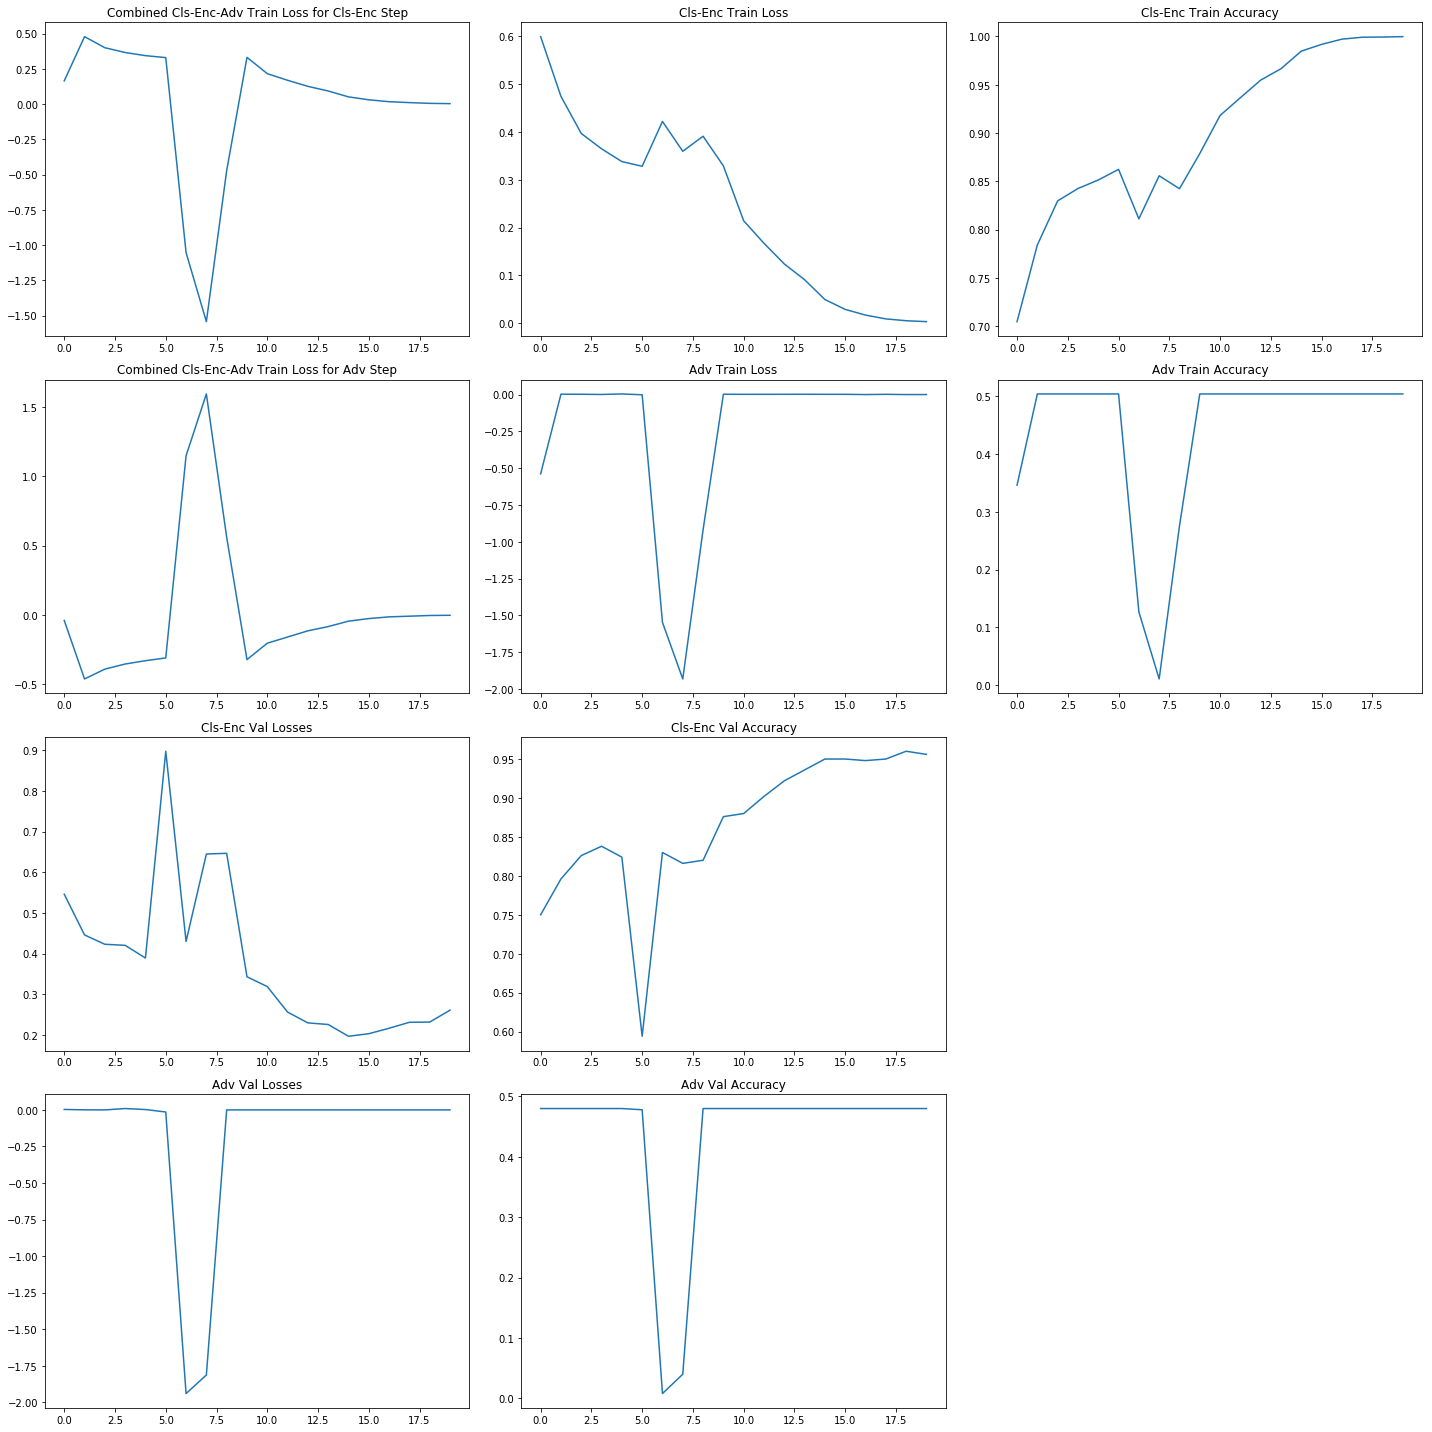

In [29]:
plt.figure(figsize=(20,20))
plt.subplot(431)
plt.title('Combined Cls-Enc-Adv Train Loss for Cls-Enc Step')
plt.plot(clsTrainCombined_losses)
plt.subplot(432)
plt.title('Cls-Enc Train Loss')
plt.plot(clsTrain_losses)
plt.subplot(433)
plt.title('Cls-Enc Train Accuracy')
plt.plot(clsTrain_accs)
plt.subplot(434)
plt.title('Combined Cls-Enc-Adv Train Loss for Adv Step')
plt.plot(advTrainCombined_losses)
plt.subplot(435)
plt.title('Adv Train Loss')
plt.plot(advTrain_losses)
plt.subplot(436)
plt.title('Adv Train Accuracy')
plt.plot(advTrain_accs)

plt.subplot(437)
plt.title('Cls-Enc Val Losses')
plt.plot(clsVal_losses)
plt.subplot(438)
plt.title('Cls-Enc Val Accuracy')
plt.plot(clsVal_accs)
plt.subplot(4,3,10)
plt.title('Adv Val Losses')
plt.plot(advVal_losses)
plt.subplot(4,3,11)
plt.title('Adv Val Accuracy')
plt.plot(advVal_accs)

plt.tight_layout()

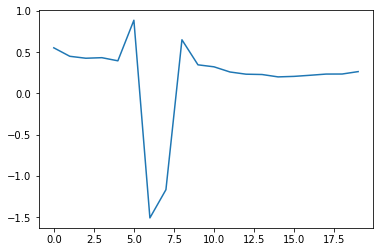

In [30]:
plt.plot(combinedVal_losses)

## check out how much info left in encoder

In [42]:
adversary = ClassNet()

In [43]:
adv_criterion = nn.BCELoss()
opt_adv = optim.Adam(adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_adv = lr_scheduler.StepLR(optimizer=opt_adv, gamma=0.99, step_size=1)

In [44]:
num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_adv_enc.step()
        scheduler_adv.step()
        # train
        train_loss, train_acc = train_classifier_epoch(advtrain_loader, laftr_encoder,
                                adversary, opt_adv, adv_criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_classifier_epoch(advval_loader, laftr_encoder, adversary,
                                 adv_criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.867 (0.867)	Loss 0.0804 (0.0804)	Accuracy 1.0000 (1.0000)
Batch: [5/40]	Time 0.021 (0.257)	Loss 0.0100 (0.0229)	Accuracy 0.9922 (0.9974)
Batch: [10/40]	Time 0.028 (0.205)	Loss 0.0074 (0.0147)	Accuracy 0.9922 (0.9979)
Batch: [15/40]	Time 0.025 (0.185)	Loss 0.0007 (0.0104)	Accuracy 1.0000 (0.9985)
Batch: [20/40]	Time 0.620 (0.203)	Loss 0.0001 (0.0084)	Accuracy 1.0000 (0.9985)
Batch: [25/40]	Time 0.024 (0.194)	Loss 0.0011 (0.0070)	Accuracy 1.0000 (0.9988)
Batch: [30/40]	Time 0.031 (0.185)	Loss 0.0013 (0.0059)	Accuracy 1.0000 (0.9990)
Batch: [35/40]	Time 0.020 (0.178)	Loss 0.0000 (0.0052)	Accuracy 1.0000 (0.9991)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 0.884 (0.884)	Loss 0.0099 (0.0099)	Accuracy 0.9922 (0.9922)
Avg validation loss: 0.009688245269586332 	 Accuracy: 0.996
--------------------
Epoch 0/20	Time 7.833 sec (7.833 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.906 (0.906)	Loss 0.0003 (0.0003)	Accuracy 1.0000 (1.0000)
Batch: [5/40]	Time 0.063 (0.269)	Loss 0.0002 (0.0007)	Accuracy 1.0000 (1.0000)
Batch: [10/40]	Time 0.024 (0.216)	Loss 0.0012 (0.0007)	Accuracy 1.0000 (1.0000)
Batch: [15/40]	Time 0.028 (0.194)	Loss 0.0037 (0.0007)	Accuracy 1.0000 (1.0000)
Batch: [20/40]	Time 0.633 (0.213)	Loss 0.0000 (0.0006)	Accuracy 1.0000 (1.0000)
Batch: [25/40]	Time 0.026 (0.200)	Loss 0.0021 (0.0007)	Accuracy 1.0000 (1.0000)
Batch: [30/40]	Time 0.036 (0.192)	Loss 0.0000 (0.0007)	Accuracy 1.0000 (1.0000)
Batch: [35/40]	Time 0.068 (0.186)	Loss 0.0003 (0.0007)	Accuracy 1.0000 (1.0000)
----------
Test: [0/4]	Time 0.819 (0.819)	Loss 0.0035 (0.0035)	Accuracy 1.0000 (1.0000)
Avg validation loss: 0.011785338994115591 	 Accuracy: 0.994
--------------------
Epoch 1/20	Time 8.166 sec (7.999 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 0.992 (0.992)	Loss 0.0000 (0.0000)	Accuracy 1.0000 (1.0000)
Batch: [5/40]	Time 0.087 (0.284)	Loss 0.000

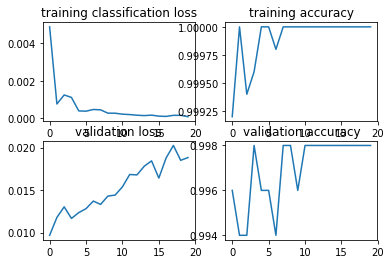

In [45]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)